## In this notebook: Fig 3F
### Note on the .mat output from idyompy: 

Each variable corresponds to a song. For each song you have the Information Content as the first dimension, and then the Relative Entropy as the second dimension. They are both vectors over the time dimension.

This was the run from the command line to generate the analyses (after cloning IDyOMpy): `python App.py -c surprisal_analysis/sub_recordings -v pitch -k -1`


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import csv
import mido
from mido import Message, MidiFile, MidiTrack, bpm2tempo
import pandas as pd
import seaborn as sns
import os
from scipy.stats import mannwhitneyu

from statannotations.Annotator import Annotator


In [6]:
def permutation_test(arr1, arr2, num_permutations=10000, alternative='two-sided', random_seed=None):
    """
    Perform a permutation test to compare the means of two distributions.
    
    Parameters:
    - arr1, arr2: 1D numpy arrays of data.
    - num_permutations: Number of permutations (default 10,000).
    - alternative: 'two-sided' (default), 'greater', or 'less' to specify the alternative hypothesis.
    - random_seed: optional int for reproducibility.
    
    Returns:
    - p-value of the permutation test.
    - observed difference in means.
    """
    if random_seed is not None:
        np.random.seed(random_seed)
        
    arr1 = np.array(arr1)
    arr2 = np.array(arr2)
    
    observed_diff = np.mean(arr1) - np.mean(arr2)
    combined = np.concatenate([arr1, arr2])
    n1 = len(arr1)
    
    count = 0
    for _ in range(num_permutations):
        np.random.shuffle(combined)
        perm_diff = np.mean(combined[:n1]) - np.mean(combined[n1:])
        
        if alternative == 'two-sided':
            if abs(perm_diff) >= abs(observed_diff):
                count += 1
        elif alternative == 'greater':
            if perm_diff >= observed_diff:
                count += 1
        elif alternative == 'less':
            if perm_diff <= observed_diff:
                count += 1
        else:
            raise ValueError("alternative must be 'two-sided', 'greater' or 'less'")
    
    p_value = (count + 1) / (num_permutations + 1)  # +1 for observed difference (avoid zero p-value)
    
    return p_value, observed_diff

def cohen_d(arr1, arr2):
    """
    Calculate Cohen's d effect size between two arrays.
    
    Parameters:
    - arr1, arr2: numpy arrays or lists of numeric data
    
    Returns:
    - Cohen's d value (float)
    """
    arr1 = np.array(arr1)
    arr2 = np.array(arr2)
    
    mean1 = np.mean(arr1)
    mean2 = np.mean(arr2)
    std1 = np.std(arr1, ddof=1)  # sample std dev
    std2 = np.std(arr2, ddof=1)
    
    n1 = len(arr1)
    n2 = len(arr2)
    
    # pooled standard deviation
    pooled_std = np.sqrt(((n1 - 1)*std1**2 + (n2 - 1)*std2**2) / (n1 + n2 - 2))
    
    d = (mean1 - mean2) / pooled_std
    
    return d


In [7]:
#surprisal data from idyom
surprisal_data = loadmat('../data_idyom/likelihoods_cross-eval_k_fold_-1_quantization_24_maxOrder_20_viewpoints_pitch.mat')
keystroke_path = '../data_idyom/keystroke_data'

#load keystrokes to find the firsts and others 
subjects_to_process = ['13','14','15','16','17','18','19','20'] #subs whose recordings were used in listening
keystroke_df = pd.DataFrame()
for sub in subjects_to_process:
    keystroke_df_sub = pd.read_csv(os.path.join(keystroke_path, f'keystrokes_{sub}_pre.csv'))
    surprisal_sub = surprisal_data[f'audio_{sub}_pre'][0]
    keystroke_df_sub['surprisal'] = surprisal_sub
    keystroke_df_sub['subject'] = sub
    keystroke_df = pd.concat([keystroke_df, keystroke_df_sub], ignore_index=True)

#make shuffled labels for permutation test
keystroke_df['epochtype_shuf'] = np.random.permutation(keystroke_df['epochtype'].values)

## Figure 3F: IDyOM analysis of melodies

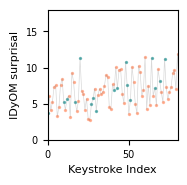

In [8]:
#plot example melody over time
sub = '13'
keystrokes_f = keystroke_df.query('subject == @sub and epochtype == "first"')
keystrokes_o = keystroke_df.query('subject == @sub and epochtype == "other"')

# Combine both and sort by index
keystrokes_all = pd.concat([keystrokes_f, keystrokes_o]).sort_index()

fig = plt.figure(figsize=(1.3, 1.3))
ax = fig.add_axes([0,0,1,1])

# Draw line connecting all points in chronological order
plt.plot(keystrokes_all.index, keystrokes_all['surprisal'].values, color='gray', alpha=0.3, linewidth = 0.5)

# Scatter points with separate colors
plt.scatter(keystrokes_f.index, keystrokes_f['surprisal'].values, color='teal', alpha=0.5, s=2)
plt.scatter(keystrokes_o.index, keystrokes_o['surprisal'].values, color='coral', alpha=0.5, s=2)

plt.xlabel('Keystroke Index', fontsize=8)
plt.ylabel('IDyOM surprisal', fontsize=8)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.ylim(0, 18)
plt.xlim(0, 80)
plt.savefig(f'./figures/keystroke_surprisal_{sub}.svg', transparent=True)


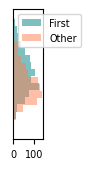

In [9]:
#plot histogram with size-matched samples
fig = plt.figure(figsize = (0.3,1.3))
ax = fig.add_axes([0,0,1,1])

n_firsts = keystroke_df.query('epochtype == "first"')['surprisal'].values.shape

plt.hist(keystroke_df.query('epochtype == "first"')['surprisal'].values, bins=50, alpha=0.5, label='First', color='teal', orientation = 'horizontal')
plt.hist(np.random.choice(keystroke_df.query('epochtype == "other"')['surprisal'].values, n_firsts), bins=50, alpha=0.5, label='Other', color='coral', orientation = 'horizontal')
plt.ylim(0,18)
# plt.ylabel('IDyOM suprisal', fontsize = 20)
# plt.xlabel('Frequency', fontsize = 20)
plt.xticks(fontsize = 7)
# plt.yticks(fontsize = 7)
plt.legend(fontsize = 9)




# plt.xticks([])
plt.yticks([])
plt.legend(fontsize = 7)
plt.savefig(f'./figures/keystroke_surprisal_hist_{sub}.svg')

In [ ]:
surprisal_f_all = keystroke_df.query('epochtype == "first"')['surprisal'].values
surprisal_o_all = keystroke_df.query('epochtype == "other"')['surprisal'].values
surprisal_fshuf_all = keystroke_df.query('epochtype_shuf == "first"')['surprisal'].values

p_value, observed_diff = permutation_test(surprisal_f_all, surprisal_o_all, num_permutations=10000, alternative='two-sided', random_seed=42)
print('permutation_test results: p value', p_value, 'observed diff', observed_diff)